<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

### **Import Libraries and Modules**

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

### **Import Dataset**

In [218]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('flotation_corrected.csv')
flotation.head().T

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


,0,1,2,3,4
iron_feed,55.200000,55.200000,55.200000,55.200000,55.200000
silica_feed,4.915479,4.915479,4.915479,4.915479,4.915479
starch_flow,323.277098,313.325639,347.948294,334.142022,340.935100
amina_flow,355.071890,300.092438,372.513415,374.194989,409.602763
pulp_flow,2.509955,3.787140,2.521700,3.781540,3.490863
pulp_pH,1.347816,1.372481,1.250439,1.061484,0.821953
pulp_density,0.214652,0.109267,0.221247,0.217251,0.289859
airflow,2645.068134,2585.175205,2606.561337,2596.452151,2594.569228
level,9.535982,9.477107,9.517626,10.684514,11.970611
iron_conc,8.623044,9.004444,8.774961,8.222164,7.925580


## **5. Machine Learning Models**

### **5.1. Splitting Dataset**

**Split Dataset as X and y**

In [219]:
X = flotation.drop(['silica_conc', 'iron_conc'], axis=1)
y_Si = flotation['silica_conc']
y_Fe = flotation['iron_conc']

print("Shape of X:", X.shape)
print("Shape of y_Si:", y_Si.shape)
print("Shape of y_Fe:", y_Fe.shape)


Shape of X: (4097, 9)
Shape of y_Si: (4097,)
Shape of y_Fe: (4097,)


### **5.2. Models For Silica Concentrate**

**Split into train, validation, and test set**

In [220]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


**Pipelines for models**

In [221]:
# Define the models and their corresponding names
models = [(LinearRegression(), 'Linear Regression'),
          (RandomForestRegressor(), 'Random Forest'),
          (xgb.XGBRegressor(), 'XGBoost'),
          (AdaBoostRegressor(), 'AdaBoost'),
          (SVR(), 'SVM'), (ElasticNet(), 'ElasticNet'),
          (DecisionTreeRegressor(), 'Decision Tree')]
    
# Create an empty list to store the evaluation scores
mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', model)])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the validation data
    val_pred = pipeline.predict(X_val)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)
    
    # Append the scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Display the evaluation metric scores
print("Mean Squared Error (MSE):")
for model_name, mse in zip([model_name for _, model_name in models], mse_scores):
    print(f"{model_name}: {mse:.3f}")

print("\nMean Absolute Error (MAE):")
for model_name, mae in zip([model_name for _, model_name in models], mae_scores):
    print(f"{model_name}: {mae:.3f}")

print("\nR-squared (R^2):")
for model_name, r2 in zip([model_name for _, model_name in models], r2_scores):
    print(f"{model_name}: {r2:.3f}")

Mean Squared Error (MSE):
Linear Regression: 0.102
Random Forest: 0.074
XGBoost: 0.075
AdaBoost: 0.096
SVM: 0.085
ElasticNet: 0.110
Decision Tree: 0.143

Mean Absolute Error (MAE):
Linear Regression: 0.268
Random Forest: 0.224
XGBoost: 0.217
AdaBoost: 0.261
SVM: 0.236
ElasticNet: 0.275
Decision Tree: 0.293

R-squared (R^2):
Linear Regression: 0.057
Random Forest: 0.317
XGBoost: 0.306
AdaBoost: 0.111
SVM: 0.218
ElasticNet: -0.010
Decision Tree: -0.314


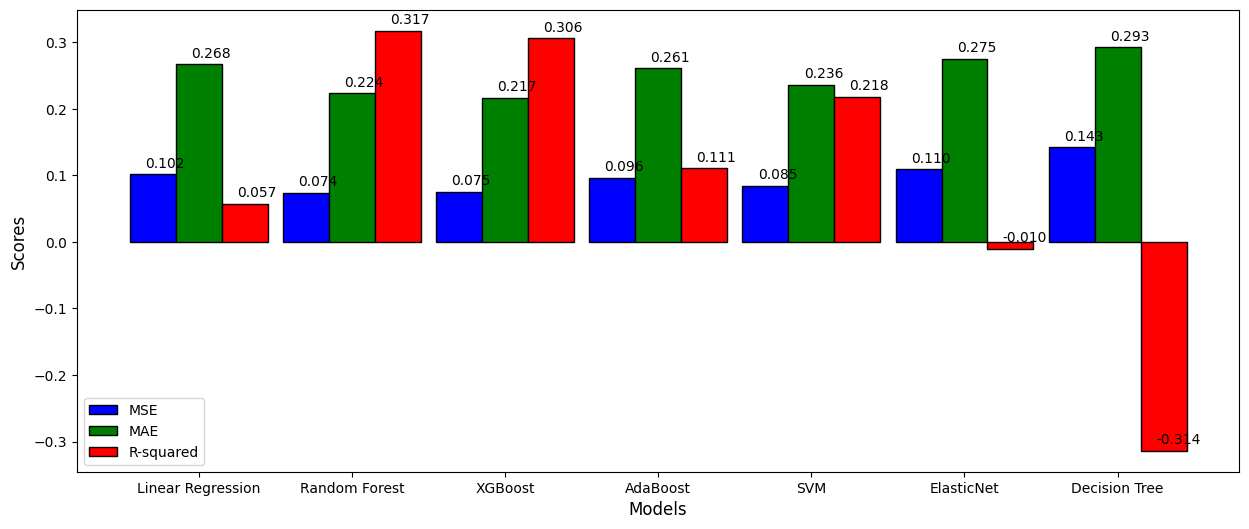

In [222]:
# Plot the evaluation metrics
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

bar_width = 0.3
plt.figure(figsize=(15, 6))
plt.bar(r1, mse_scores, color='b', width=bar_width, edgecolor='black', label='MSE')
plt.bar(r2, mae_scores, color='g', width=bar_width, edgecolor='black', label='MAE')
plt.bar(r3, r2_scores, color='r', width=bar_width, edgecolor='black', label='R-squared')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.xticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='lower left')

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(i - 0.05, mse + 0.01, f'{mse:.3f}', color='black')
    plt.text(i + bar_width - 0.05, mae + 0.01, f'{mae:.3f}', color='black')
    plt.text(i + 2 * bar_width - 0.05, r2 + 0.01, f'{r2:.3f}', color='black')

plt.show()

**Discussion for Silica Concentrate Prediction**

The Random Forest model achieves the lowest Mean Squared Error (MSE) of 0.074, indicating that its predictions have the smallest squared differences from the actual values on average. It also obtains the lowest Mean Absolute Error (MAE) of 0.224, indicating the smallest average absolute differences between its predictions and the actual values. Moreover, it exhibits the highest R-squared (R^2) value of 0.317, indicating that it explains a larger portion of the variance in the data compared to the other models.

XGBoost model performs exceptionally well with a low MSE of 0.075, a low MAE of 0.217, and a high R^2 of 0.306. These metrics demonstrate its accuracy, precision, and ability to capture the underlying patterns in the data.

Linear Regression, AdaBoost, SVM, ElasticNet, and Decision Tree models also achieve relatively lower MSE and MAE values compared to the other models, they exhibit lower R^2 values. This suggests that they explain less of the variance in the data and may not capture the underlying relationships as effectively.

Both the Random Forest and XGBoost models are strong choices for this dataset, as they consistently outperform the other models in terms of accuracy, precision, and variance explanation.

### **5.2. Models For Iron Concentrate**

**Split into train, validation, and test set**

In [223]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Fe, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


**Pipelines for models**

In [224]:
# Define the models and their corresponding names
models = [(LinearRegression(), 'Linear Regression'),
          (RandomForestRegressor(), 'Random Forest'),
          (xgb.XGBRegressor(), 'XGBoost'),
          (AdaBoostRegressor(), 'AdaBoost'),
          (SVR(), 'SVM'), (ElasticNet(), 'ElasticNet'),
          (DecisionTreeRegressor(), 'Decision Tree')]
    
# Create an empty list to store the evaluation scores
mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', model)])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the validation data
    val_pred = pipeline.predict(X_val)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)
    
    # Append the scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Display the evaluation metric scores
print("Mean Squared Error (MSE):")
for model_name, mse in zip([model_name for _, model_name in models], mse_scores):
    print(f"{model_name}: {mse:.3f}")

print("\nMean Absolute Error (MAE):")
for model_name, mae in zip([model_name for _, model_name in models], mae_scores):
    print(f"{model_name}: {mae:.3f}")

print("\nR-squared (R^2):")
for model_name, r2 in zip([model_name for _, model_name in models], r2_scores):
    print(f"{model_name}: {r2:.3f}")

Mean Squared Error (MSE):
Linear Regression: 4.040
Random Forest: 3.064
XGBoost: 3.240
AdaBoost: 3.833
SVM: 3.732
ElasticNet: 4.361
Decision Tree: 6.035

Mean Absolute Error (MAE):
Linear Regression: 1.640
Random Forest: 1.379
XGBoost: 1.401
AdaBoost: 1.598
SVM: 1.537
ElasticNet: 1.681
Decision Tree: 1.849

R-squared (R^2):
Linear Regression: 0.073
Random Forest: 0.297
XGBoost: 0.256
AdaBoost: 0.120
SVM: 0.143
ElasticNet: -0.001
Decision Tree: -0.385


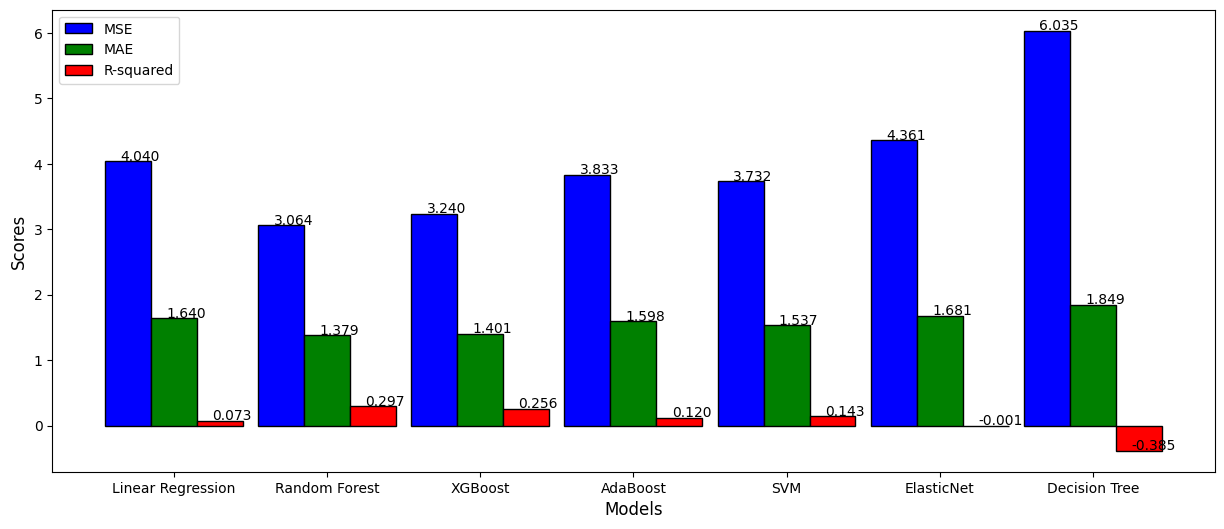

In [225]:
# Plot the evaluation metrics
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

bar_width = 0.3
plt.figure(figsize=(15, 6))
plt.bar(r1, mse_scores, color='b', width=bar_width, edgecolor='black', label='MSE')
plt.bar(r2, mae_scores, color='g', width=bar_width, edgecolor='black', label='MAE')
plt.bar(r3, r2_scores, color='r', width=bar_width, edgecolor='black', label='R-squared')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.xticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='upper left')

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(i - 0.05, mse + 0.01, f'{mse:.3f}', color='black')
    plt.text(i + bar_width - 0.05, mae + 0.01, f'{mae:.3f}', color='black')
    plt.text(i + 2 * bar_width - 0.05, r2 + 0.01, f'{r2:.3f}', color='black')

plt.show()

**Discussion for Iron Concentrate Prediction**

- Random Forest model consistently outperforms the others in terms of Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2).

- The Random Forest model achieves the lowest MSE value of 3.064, indicating that its predictions have the smallest squared differences from the actual values on average. It also exhibits the lowest MAE value of 1.379, indicating the smallest average absolute differences between its predictions and the actual values. Furthermore, it obtains the highest R-squared value of 0.297, implying that it explains a larger portion of the variance in the data compared to the other models.

- The other models, including Linear Regression, XGBoost, AdaBoost, SVM, ElasticNet, and Decision Tree, demonstrate relatively higher MSE and MAE values and lower R-squared values. This suggests that their predictions have larger errors, both in terms of squared differences and absolute differences, and they explain less variance in the data compared to the Random Forest model.

- Random Forest model provides the most accurate and precise predictions, as well as a better understanding of the underlying patterns in the data. Therefore, the Random Forest model is the recommended choice for this particular dataset.

### **5.3. Overall Conclusion**

In this study, we compared the performance of various regression models, including Linear Regression, Random Forest Regression, XGBoost Regression, AdaBoost Regression, SVM Regression, ElasticNet Regression, and Decision Tree Regression, for predicting the concentrations of iron and silica in mineral processing. 

Our findings demonstrate that all the models provided reasonably accurate predictions, with comparable results observed. However, some variations were observed in their performance metrics.

Linear Regression, being a simpler model, exhibited decent predictive capability but had limitations in capturing complex nonlinear relationships within the dataset. Random Forest Regression and XGBoost Regression, as ensemble models, showcased excellent predictive accuracy, owing to their ability to capture complex interactions among features. AdaBoost Regression also showed promising results, leveraging the concept of boosting to improve prediction accuracy.

Support Vector Machine (SVM) Regression demonstrated decent performance but lagged slightly behind the ensemble models. ElasticNet Regression, with its combination of L1 and L2 regularization, exhibited moderate predictive capability, striking a balance between linear and non-linear relationships. Decision Tree Regression performed adequately but was prone to overfitting the training data.

Based on these results, engineers in the mineral processing industry can select the most appropriate model considering the trade-offs between prediction accuracy, interpretability, and computational complexity. Ensemble models such as Random Forest and XGBoost are recommended for accurate predictions, particularly when dealing with complex datasets. Linear Regression and SVM Regression can be suitable choices for applications that prioritize interpretability and simplicity.